## i. Introduction

By: George Kenji Putra

Dataset: **Plant Disease Recognition**

This dataset consists of 1530 images categorized into three labels: `Healthy`, `Powdery`, and `Rust`, representing different plant conditions. The objective of utilizing this dataset is to assist an agricultural business in quickly identifying unhealthy plants without the need for human intervention. By developing an automated system trained on this dataset, the business aims to expedite the detection process, enabling timely interventions to prevent crop losses and maximize yields.

The agricultural business recognizes the importance of timely identification and intervention in plant health to optimize agricultural practices. By leveraging the dataset's labeled images, the business intends to train a Computer Vision model capable of accurately classifying plant conditions. The system will enable field workers or farmers to capture images of plants, submit them to the automated system, and receive prompt feedback on the plant's health status. This automated approach not only saves valuable time and resources but also allows for targeted treatments and proactive disease management, ensuring a sustainable and profitable agricultural operation. 

For more information, kindly visit [here](https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset).

Objective: 

This project aims to develop an automated system that can accurately identify and classify plant diseases using computer vision techniques. By analyzing images of plant leaves, the system can detect diseases early, enabling timely interventions for improved crop health and productivity.

Deployment : For model deployment, please visit here: [Hugging Face](https://huggingface.co/spaces/agayabag/deploy_plant_disease_recognition).

Colab      : For Google Colab file, please visit here: [Google Colab](https://drive.google.com/file/d/1fSM1MmBnalqG2qQ3yxi74PHlqEJUJfV4/view?usp=sharing)

## ii. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
from skimage.color import rgb2gray

import warnings
warnings.filterwarnings('ignore')

## iii. Data Loading and Overview

### iii.i Google Colab Folder Manipulation

In [2]:
# deleting the sample_data folder from google colab

shutil.rmtree('/content/sample_data')

In [3]:
# processing the kaggle.json in order to gain access to kaggle right away

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!mkdir ./kaggle
!mv ./kaggle.json ./kaggle

!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


### iii.ii Downloading and Processing the Dataset 

In [4]:
# downloading the dataset

!kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset

# unzipping the dataset

!unzip -q /content/plant-disease-recognition-dataset.zip -d images

 99% 1.23G/1.25G [00:13<00:00, 139MB/s]
100% 1.25G/1.25G [00:13<00:00, 97.6MB/s]


### iii.iii Dataset's Folders Manipulation

The existing folder structure of our dataset appears to be <mark>disorganized and lacking in a professional layout</mark>. To address this issue, we have decided to <mark>simplify and optimize the folder structure</mark> for improved clarity and ease of use. By reorganizing the folders in a more logical and intuitive manner, we aim to enhance the overall management and accessibility of the dataset.

In [5]:
# manipulating the Test folder

shutil.move('/content/images/Test/Test/Healthy', '/content/images/Test/')
shutil.move('/content/images/Test/Test/Powdery', '/content/images/Test/')
shutil.move('/content/images/Test/Test/Rust', '/content/images/Test/')
shutil.rmtree('/content/images/Test/Test')

In [6]:
# manipulating the Train folder

shutil.move('/content/images/Train/Train/Healthy', '/content/images/Train/')
shutil.move('/content/images/Train/Train/Powdery', '/content/images/Train/')
shutil.move('/content/images/Train/Train/Rust', '/content/images/Train/')
shutil.rmtree('/content/images/Train/Train')

After evaluating our dataset, we have identified an opportunity to enhance its structure for better efficiency and clarity. Currently, the dataset comprises three main folders: `Train`, `Test`, and `Validation`. 

To streamline our workflow, we will <mark>exclude</mark> the `Validation` folder and <mark>merge</mark> its contents with the `Train` folder. This consolidation will create a more unified dataset. Going forward, we will <mark>define</mark> a separate <mark>Validation dataset</mark> using a subset of images <mark>from the merged Train folder</mark>. 

This approach ensures a coherent and organized dataset, optimizing our resources for improved model training, testing, and validation. Our commitment to professionalism drives these efforts to facilitate seamless and effective data management.

In [7]:
# moving every pictures from validation folder to train folder

source_dir = '/content/images/Validation/Validation/Healthy'  # val_healthy to train_healthy
destination_dir = '/content/images/Train/Healthy'

files = os.listdir(source_dir)
for file in files:
    source_path = os.path.join(source_dir, file)
    destination_path = os.path.join(destination_dir, file)
    shutil.move(source_path, destination_path)

os.rmdir(source_dir)

source_dir = '/content/images/Validation/Validation/Powdery'  # val_powdery to train_powdery
destination_dir = '/content/images/Train/Powdery'

files = os.listdir(source_dir)
for file in files:
    source_path = os.path.join(source_dir, file)
    destination_path = os.path.join(destination_dir, file)
    shutil.move(source_path, destination_path)

os.rmdir(source_dir)

source_dir = '/content/images/Validation/Validation/Rust' # val_rust to train_rust
destination_dir = '/content/images/Train/Rust'

files = os.listdir(source_dir)
for file in files:
    source_path = os.path.join(source_dir, file)
    destination_path = os.path.join(destination_dir, file)
    shutil.move(source_path, destination_path)

# remove the Validation folder

shutil.rmtree('/content/images/Validation')

### iii.iv Dataset Overview and Handling Imbalance (If Needed)

Following the folder restructuring, our next step involves conducting a study of the folder contents.

In [8]:
# defining the directory for train, and test dataset

train_dir = '/content/images/Train'
test_dir = '/content/images/Test'

In [9]:
# checking how many pictures we have for each directory

def check_dir(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'Total {label} : {num_data}')

print('train-set: \n' + '_'*25) 
check_dir(train_dir,['Healthy', 'Powdery', 'Rust'])

print('\ntest-set: \n' + '_'*25) 
check_dir(test_dir,['Healthy', 'Powdery', 'Rust'])

train-set: 
_________________________
Total Healthy : 478
Total Powdery : 450
Total Rust : 454

test-set: 
_________________________
Total Healthy : 50
Total Powdery : 50
Total Rust : 50


We have noticed a <mark>slight imbalance</mark> within the `train-set` folder, which could potentially <mark>lead to biased predictions</mark>. To rectify this issue and ensure fairness in our predictions, we will take steps to <mark>equalize the number of pictures in each folder</mark>.

In [10]:
# set the desired number of images for each class in the train-set

desired_num_images = 450

# function to move excess images from the train-set to a separate directory

def move_excess_images(dir = None, label = None):
    files = os.listdir(os.path.join(dir, label))
    if len(files) > desired_num_images:
        
        # create a new folder for the excess images
        
        excess_dir = os.path.join(dir, 'excess_images', label)
        os.makedirs(excess_dir, exist_ok=True)
        
        # move excess images to the new folder
        
        excess_files = random.sample(files, len(files) - desired_num_images)
        for file in excess_files:
            shutil.move(os.path.join(dir, label, file), os.path.join(excess_dir, file))

# move excess images from the train-set to separate folders for each class

for label in ['Healthy', 'Powdery', 'Rust']:
    move_excess_images(train_dir, label)

# move the entire 'excess_images' folder to the main directory

shutil.move(os.path.join(train_dir, 'excess_images'), '/content/')

# print the updated number of pictures for each directory

print('train-set: \n' + '_'*25) 
check_dir(train_dir, ['Healthy', 'Powdery', 'Rust'])

print('\ntest-set: \n' + '_'*25) 
check_dir(test_dir, ['Healthy', 'Powdery', 'Rust'])

train-set: 
_________________________
Total Healthy : 450
Total Powdery : 450
Total Rust : 450

test-set: 
_________________________
Total Healthy : 50
Total Powdery : 50
Total Rust : 50


With the successful achievement of a balanced dataset in both the train-set and test-set folders, we are now ready to proceed to the next stage of our analysis: Exploratory Data Analysis (EDA).

## iv. Exploratory Data Analysis (EDA)

In this phase, we will delve deeper into the dataset to gain valuable insights. By conducting a comprehensive EDA, we aim to extract meaningful information that will inform our subsequent modeling decisions and contribute to the overall understanding of the underlying data.

### iv.i Observing the Images (Random Sample)

In this section, our objective is to perform a <mark>random sampling</mark> of the `training` dataset to gain valuable insights. This process allows us to observe key characteristics such as the shape of the images and assess whether a uniform shape is maintained throughout the dataset. 

Additionally, by carefully examining the sampled images, we can identify any anomalous or unconventional pictures that may require special attention. This comprehensive analysis provides us with a deeper understanding of the dataset, enabling us to make informed decisions and take appropriate actions in subsequent stages of our project.

In [11]:
# storing the images inside the train folder into variables according to the class

train_healthy = glob.glob(train_dir + '/Healthy/*.jpg')
train_powdery = glob.glob(train_dir + '/Powdery/*.jpg')
train_rust = glob.glob(train_dir + '/Rust/*.jpg')

In [12]:
# defining a random sample picker

def random_sample(image_files, num_samples=7):
  random_files = random.sample(image_files, num_samples)
  return random_files

In [13]:
# applying the random sample picker to the previous variables

random_train_healthy = random_sample(train_healthy)
random_train_powdery = random_sample(train_powdery)
random_train_rust = random_sample(train_rust)

In [14]:
# showing the random sample files from train_healthy folder

random_train_healthy

['/content/images/Train/Healthy/9a71889a93779996.jpg',
 '/content/images/Train/Healthy/91ec138593c7d1ba.jpg',
 '/content/images/Train/Healthy/90d162cfad5c7853.jpg',
 '/content/images/Train/Healthy/8c8c3cb823c657fc.jpg',
 '/content/images/Train/Healthy/88ea5295af60d477.jpg',
 '/content/images/Train/Healthy/9e004fca3675d63c.jpg',
 '/content/images/Train/Healthy/95a15a575b4ba8a9.jpg']

In [15]:
# defining colored image plotter

def visualize_img(random_data, labels=None):
    fig, axes = plt.subplots(1, 7, figsize=(21, 14))
    for i, image_path in enumerate(random_data):
        image = plt.imread(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f'{labels}, {image.shape}')
        axes[i].axis('off')
    plt.show()

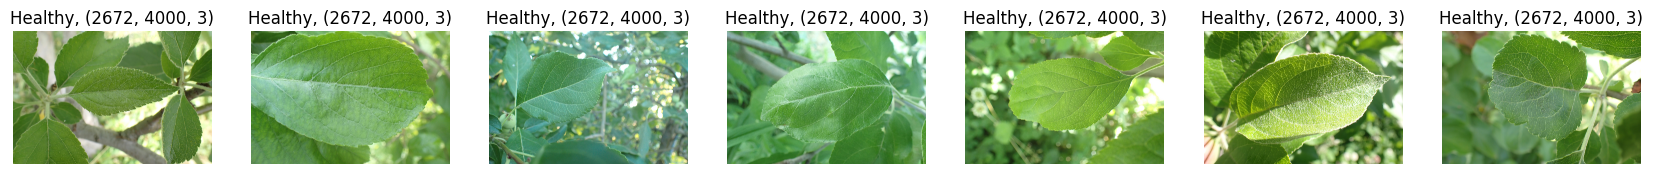

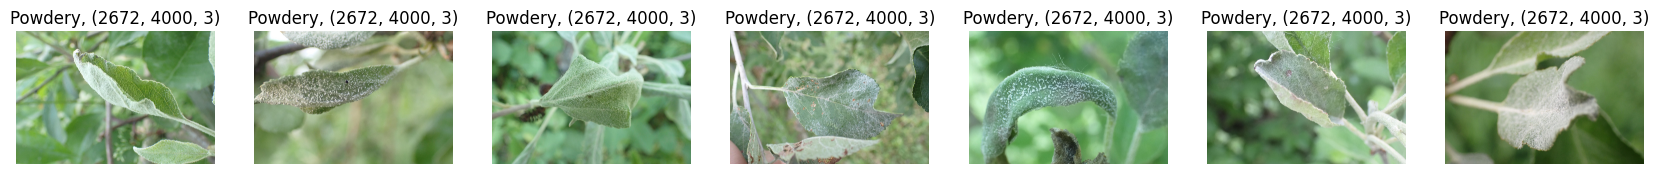

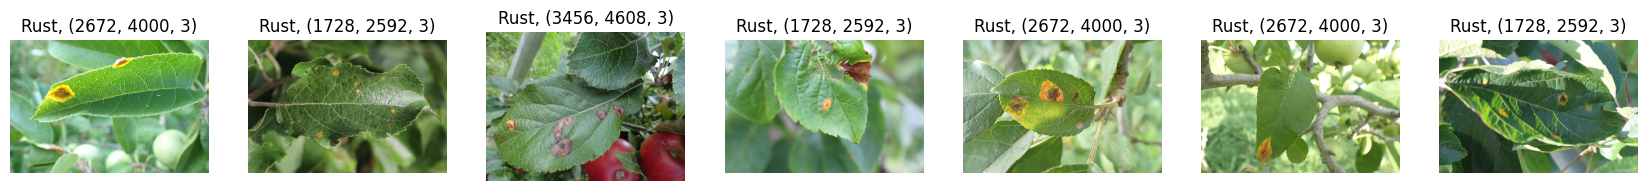

In [16]:
# showing the randomly picked images from all the classes

visualize_img(random_train_healthy, 'Healthy')
visualize_img(random_train_powdery, 'Powdery')
visualize_img(random_train_rust, 'Rust')

Based on the images presented, we can observe that the <mark>picture sizes are not uniform</mark>, indicating a lack of consistency in their dimensions. However, it is reassuring to note that there are no apparent abnormalities or anomalies within the displayed images. 

This information provides valuable insights into the dataset's characteristics, highlighting the need to address the non-uniformity of image sizes for improved compatibility in subsequent modeling tasks. By ensuring consistent image sizes, we can enhance the dataset's overall quality and align with professional standards throughout our analysis.

### iv.ii Image Augmentation

In this section, we will show the result of <mark>image augmentation</mark> using the following parameters: 

- `Shearing`: 0.25
- `Zoom`: 0.25
- `Rotation`: 10

These augmentation conditions will also be applied during the preprocessing step to ensure consistency throughout the data transformation process. By incorporating these techniques, such as shearing, zooming, and rotation, we aim to enhance the diversity and adaptability of the dataset. This augmentation process will enable the model to learn from a wider range of variations and improve its performance on unseen data.

In [17]:
# function to apply shear transformation

def shear(image, shear_range):
    rows, cols, channels = image.shape
    shear_matrix = np.array([[1, shear_range, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float32)
    sheared_image = cv2.warpPerspective(image, shear_matrix, (cols, rows))
    return sheared_image

# function to apply zoom transformation

def zoom(image, zoom_range):
    zoomed_image = cv2.resize(image, None, fx=zoom_range, fy=zoom_range)
    return zoomed_image

# function to apply rotation transformation

def rotate(image, rotation_range):
    rows, cols, channels = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), rotation_range, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    return rotated_image

In [18]:
# defining a grayscaled  image plotter

def visualize_augmented_images(image_files, augmentation_params, labels):
    fig, axes = plt.subplots(1, len(image_files), figsize=(21, 14))
    
    for i, image_path in enumerate(image_files):
        image = plt.imread(image_path)
        augmented_image = shear(image, augmentation_params['shear'])
        augmented_image = zoom(augmented_image, augmentation_params['zoom'])
        augmented_image = rotate(augmented_image, augmentation_params['rotation'])
        augmented_image_gray = rgb2gray(augmented_image)
        image_label = labels[i]
        
        axes[i].imshow(augmented_image_gray, cmap='gray')
        axes[i].set_title(f'Aug {image_label}, {augmented_image_gray.shape}')
        axes[i].axis('off')
    
    plt.show()

# defining the augmentation parameters

augmentation_params = {'shear': 0.25, 'zoom': 0.25, 'rotation': 10}

In [19]:
# specify the labels for the randomly picked images

labels_train_healthy = ['Healthy'] * len(random_train_healthy)
labels_train_powdery = ['Powdery'] * len(random_train_powdery)
labels_train_rust = ['Rust'] * len(random_train_rust)

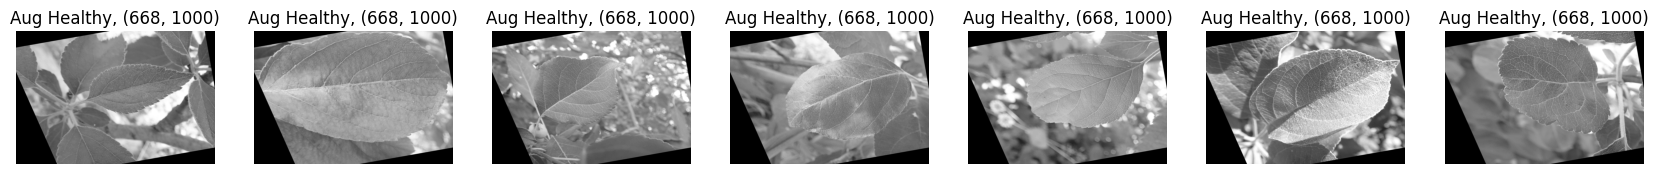

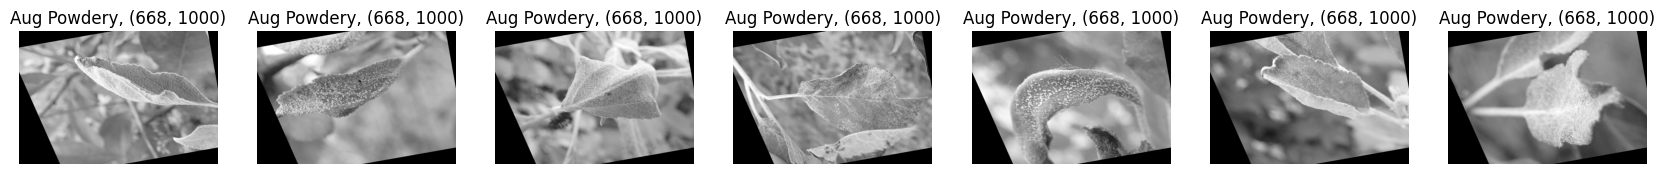

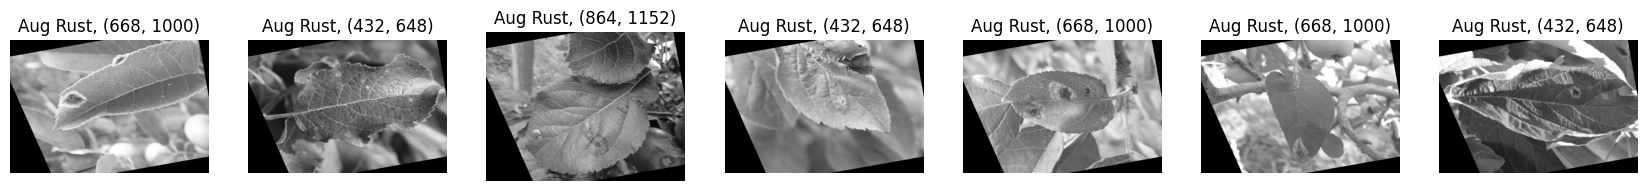

In [20]:
# visualize augmented images for each class

visualize_augmented_images(random_train_healthy, augmentation_params, labels_train_healthy)
visualize_augmented_images(random_train_powdery, augmentation_params, labels_train_powdery)
visualize_augmented_images(random_train_rust, augmentation_params, labels_train_rust)

Now that we have observed the effects of image augmentation, we can proceed to the Feature Engineering phase.

## v. Feature Engineering

In this section, we will set up <mark>data generators</mark> and prepare the dataset for training and evaluation of our model. 

Data generators play a crucial role in dynamically loading and <mark>preprocessing images</mark> from the dataset during the model training process. They act as intermediaries between the image files stored on disk and the model, enabling efficient and on-the-fly data augmentation and preprocessing.

Using <mark>data generators</mark> offers several <mark>advantages</mark>. It allows us to <mark>handle large datasets</mark> that may not fit entirely in memory, <mark>efficiently preprocess the images</mark> according to our requirements, and <mark>apply real-time augmentation techniques</mark> during training. These benefits contribute to enhancing the model's generalization capabilities and improving its overall performance.

In [21]:
# defining train and test data generator

train_gen = ImageDataGenerator(
                rescale = 1. / 255,
                validation_split = 0.2, 
                shear_range = 0.25, 
                zoom_range = 0.25,
                rotation_range = 10) 
  
test_gen = ImageDataGenerator(rescale = 1. / 255)

# applying the data generator to each dataset

train_dataset = train_gen.flow_from_directory(train_dir, target_size=(240, 240), batch_size = 128, color_mode='rgb',
                                              class_mode='categorical', subset='training', seed = 42, shuffle = 1024)

val_dataset = train_gen.flow_from_directory(train_dir, target_size=(240, 240), batch_size = 128, color_mode='rgb',
                                            class_mode='categorical', subset='validation', seed = 42, shuffle = False)

test_dataset = test_gen.flow_from_directory(
                  test_dir, target_size=(240, 240), batch_size = 128, color_mode='rgb',
                  class_mode='categorical', seed = 42, shuffle = False)

print('')
print('Class names for our dataset:')
train_dataset.class_indices

Found 1080 images belonging to 3 classes.
Found 270 images belonging to 3 classes.
Found 150 images belonging to 3 classes.

Class names for our dataset:


{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

In [22]:
# assigning a variable to keep the name of the dataset

class_name = ['Healthy', 'Powdery', 'Rust']

## vi. Model Definition

In this assignment, we will make Computer Vision (CV) model using <mark>Sequential API</mark>.

In [23]:
# clear session

seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [24]:
# create sequential model

model = Sequential()

model.add(Conv2D(8, 3, activation='relu', input_shape=(240, 240, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

# showing the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 53824)             0         
                                                                 
 dense (Dense)               (None, 3)                 1

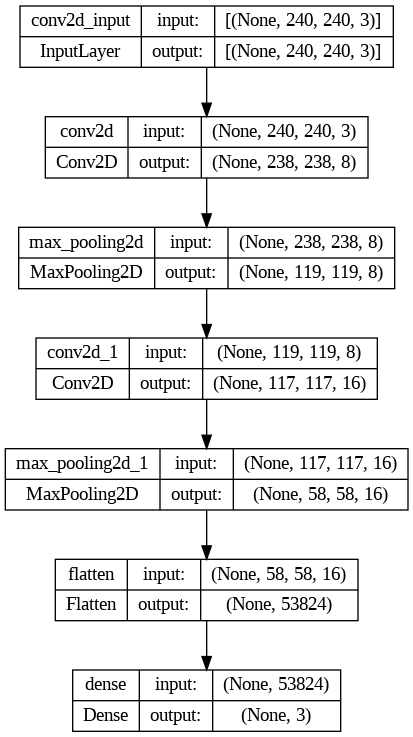

In [25]:
# showing the model architecture

plot_model(model, to_file='model_sequential_architecture.png', show_shapes=True)

Model architecture explanation for the model:

* **Convolutional Layer 1**

The first layer added to the model is a <mark>2D convolutional layer (Conv2D)</mark>. It has 8 filters with a kernel size of 3x3, resulting in 224 parameters. The activation function used is `ReLU` (Rectified Linear Unit). The layer expects input images of shape (240, 240, 3), representing `RGB` color images.

* **Max Pooling Layer 1** 

A <mark>max pooling layer (MaxPooling2D)</mark> is added after the first convolutional layer. It reduces the spatial dimensions of the previous layer by taking the maximum value within a sliding window. The default pool size of 2x2 is used, effectively reducing the output shape by half.

* **Convolutional Layer 2**

Another `Conv2D` layer is added to the model. This layer has 16 filters with a kernel size of 3x3, resulting in 1,168 parameters. It also uses the `ReLU` activation function.

* **Max Pooling Layer 2**

A <mark>second max pooling layer</mark> is added after the second convolutional layer. It has the default pool size of 2x2. It reduces the spatial dimensions by half.

* **Flatten Layer**

A `flatten` layer is added to the model. <mark>It transforms the multidimensional output from the previous layer into a 1D vector, preparing it for input into a dense layer</mark>. The flatten layer has no parameters since it performs reshaping.

* **Output Layer**

A dense (fully connected) layer is added to the model. It has <mark>3 units/neurons, representing the output classes of the model</mark>. The activation function used is `softmax`, which produces probabilities for each class. It produces 161,475 parameters.

* **Parameters**

The total number of `trainable params` in the model is 162,867, which are the ones that will be updated during training. While `non-trainable params` indicates the number of non-trainable parameters, which remain constant during training (such as in the case of frozen layers).

## vii. Model Training

In general, the purposes of training the model are to generalize well to new data, accurately predict or classify new data points, and enable decision-making. In this section, all baseline models will be trained.

In [26]:
# compiling the model

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

# training the model

history = model.fit(train_dataset,
                    epochs = 25,
                    validation_data = val_dataset)

Epoch 1/25
9/9 [==============================] - 287s 31s/step - loss: 2.4531 - accuracy: 0.3315 - val_loss: 1.6047 - val_accuracy: 0.3333
Epoch 2/25
9/9 [==============================] - 224s 25s/step - loss: 1.2432 - accuracy: 0.3620 - val_loss: 1.1009 - val_accuracy: 0.3407
Epoch 3/25
9/9 [==============================] - 221s 25s/step - loss: 1.0164 - accuracy: 0.4741 - val_loss: 0.9451 - val_accuracy: 0.5296
Epoch 4/25
9/9 [==============================] - 220s 25s/step - loss: 0.8130 - accuracy: 0.7176 - val_loss: 0.7470 - val_accuracy: 0.6519
Epoch 5/25
9/9 [==============================] - 220s 25s/step - loss: 0.5875 - accuracy: 0.7676 - val_loss: 0.5760 - val_accuracy: 0.7333
Epoch 6/25
9/9 [==============================] - 222s 25s/step - loss: 0.4899 - accuracy: 0.8065 - val_loss: 0.5511 - val_accuracy: 0.7481
Epoch 7/25
9/9 [==============================] - 219s 26s/step - loss: 0.4201 - accuracy: 0.8361 - val_loss: 0.5623 - val_accuracy: 0.7630
Epoch 8/25
9/9 [====

In [27]:
# showing the evaluation scores of the model to test dataset

results = model.evaluate(test_dataset)

print(f'Test-set Loss     : {results[0]:.2f}')
print(f'Test-set Accuracy : {results[1]:.2f}')

2/2 [==============================] - 20s 4s/step - loss: 0.5151 - accuracy: 0.8267
Test-set Loss     : 0.52
Test-set Accuracy : 0.83


For compiling the model, we utilized `categorical_crossentropy` as the loss function, which is <mark>suitable for multi-class classification</mark> tasks. The optimizer is set to `Adam`, an <mark>efficient optimization algorithm</mark>. The evaluation metric is `accuracy`, which measures the proportion of correctly classified samples.

As for the training the model, we train the model using the provided the training dataset. The `epochs` parameter is set to 25, indicating the number of times the model will iterate over the entire training dataset during training. The validation dataset is used to evaluate the model's performance during training. The training `history`, including metrics and loss values at each epoch, is stored in the history variable.

Finally, the test-set <mark>loss is displayed as 0.52</mark>, indicating the average loss value calculated during the evaluation. The test-set <mark>accuracy is shown as 0.83</mark>, representing the proportion of correctly classified samples in the test dataset.

## viii. Model Evaluation

### viii.i Predict and Insightful Plots

In [28]:
# creating dataFrame for the model history in order to make it easy to plot

history_df = pd.DataFrame(history.history)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.195188,0.934259,0.338139,0.866667
21,0.191341,0.936111,0.318768,0.874074
22,0.183761,0.941667,0.367453,0.866667
23,0.169553,0.941667,0.348475,0.840741
24,0.158228,0.959259,0.296166,0.888889


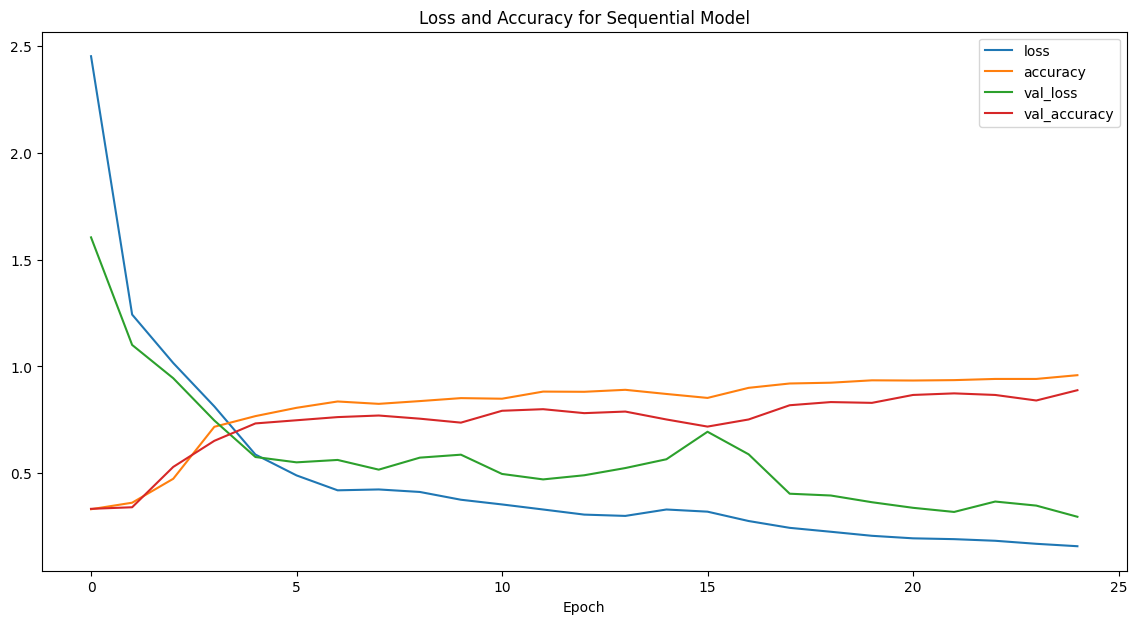

In [29]:
# showing the loss and accuracy graph for the model

history_df.plot(figsize=(14, 7))
plt.title('Loss and Accuracy for Sequential Model')
plt.xlabel('Epoch')
plt.show()

In [30]:
# evaluate the model test-set

y_pred = model.predict_generator(test_dataset, 150 // 128+1)
y_pred = np.argmax(y_pred, axis=1)
report = classification_report(test_dataset.classes, y_pred, target_names = class_name)

print('Classification Report for Sequential API model test-set')
print(report)

Classification Report for Sequential API model test-set
              precision    recall  f1-score   support

     Healthy       0.75      0.84      0.79        50
     Powdery       0.98      0.86      0.91        50
        Rust       0.78      0.78      0.78        50

    accuracy                           0.83       150
   macro avg       0.84      0.83      0.83       150
weighted avg       0.84      0.83      0.83       150



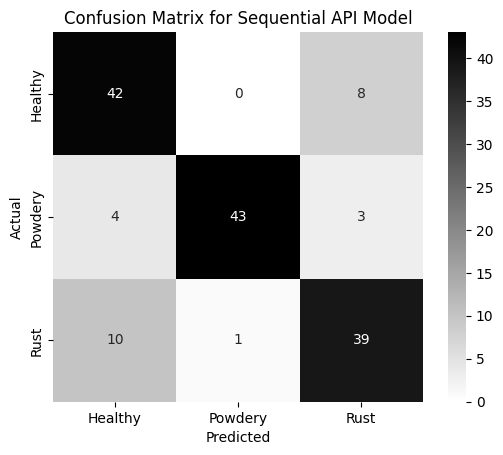

In [31]:
# showing confusion matrix for the model

cm = confusion_matrix(test_dataset.classes, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cbar = True, square = True, cmap = 'binary',
              xticklabels = class_name, yticklabels = class_name)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Sequential API Model')
plt.show()

Based on the plot, the model appears to be a <mark>good fit</mark> as there is little gap between the loss and accuracy lines compared to their validation counterparts. The model achieves an <mark>accuracy score of around 83%</mark> and a <mark>loss of approximately 30%</mark>. After around <mark>20 epochs</mark>, both the <mark>loss and accuracy stabilize</mark>.

In the case of plant disease recognition with classes for healthy, powdery, and rust, <mark>prioritizing accuracy</mark> is recommended. This is because a <mark>balanced training dataset</mark> allows for a focus on <mark>achieving precise classifications for each class</mark>. Given that <mark>different treatments</mark> or interventions may be <mark>required based on the identified disease</mark>, accurate classification becomes crucial. 

By emphasizing <mark>accuracy</mark> as the evaluation metric, the objective is to <mark>maximize the overall correct classification rate</mark>. This ensures that the model reliably identifies the presence or absence of diseases across the different classes, enabling <mark>effective decision-making</mark> in plant disease recognition. 

After analyzing the <mark>confusion matrix</mark>, it is clear that our current model faces <mark>difficulties</mark> in accurately predicting the correct class. We observe an <mark>error rate of around 20%</mark> for each class during the prediction process. To address these challenges, our next step will involve refining and improving the model. We will explore different strategies and approaches to enhance the accuracy and precision of our model with the aim to optimize the performance and ensure more reliable predictions for identifying plant diseases.

### viii.ii Models Improvement

In this section, we will attemp to imrpove the results of our model by <mark>introducing a pre-trained model</mark> named `InceptionResNetV2`. InceptionResNetV2 offers <mark>strong performance and accuracy</mark>, making it well-suited for various computer vision tasks. However, its <mark>computational complexity and memory requirements should be considered</mark>, and the interpretability of its learned representations may be less straightforward.

In [32]:
# clear session

tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [33]:
# load pre-trained model

irnv2 = InceptionResNetV2(include_top = False, weights = 'imagenet', input_shape=(240, 240, 3), pooling='max')
irnv2.trainable = False

219055592/219055592 [==============================] - 1s 0us/step


In [34]:
# creating the improved model

model_imp = Sequential()

model_imp.add(irnv2)
model_imp.add(Dropout(0.2))
model_imp.add(Flatten())
model_imp.add(BatchNormalization())
model_imp.add(Dense(1024, kernel_initializer = 'he_uniform'))
model_imp.add(BatchNormalization())
model_imp.add(Activation('relu'))
model_imp.add(Dropout(0.5))
model_imp.add(Dense(512,kernel_initializer = 'he_uniform'))
model_imp.add(BatchNormalization())
model_imp.add(Activation('relu'))
model_imp.add(Dropout(0.5))
model_imp.add(Dense(3, activation='softmax'))

# showing the improved model summary

model_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 batch_normalization_203 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 batch_normalization_204 (Ba  (None, 1024)             4

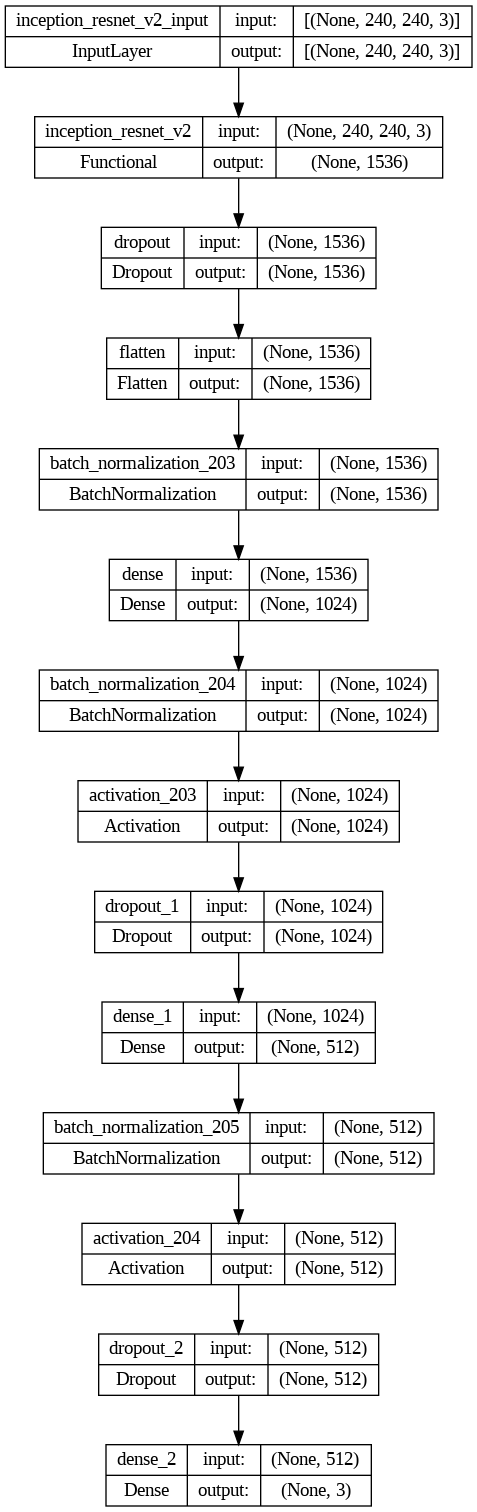

In [35]:
# showing the improved model architecture

plot_model(model_imp, to_file='model_imp_sequential_architecture.png', show_shapes=True)

Model architecture explanation for the code:

* **InceptionResNetV2 Base Model**

A pre-trained model called InceptionResNetV2 is used which serves as the base model for feature extraction. The model is initialized with weights pre-trained on the ImageNet dataset. The `include_top` parameter is set to `False` to exclude the fully connected layers, and the `input_shape` is specified as (240, 240, 3), indicating the input image dimensions of 240x240 pixels with 3 color channels (RGB). The global maximum pooling operation is applied as the pooling strategy. It produces feature vectors of length 1536.

* **Dropout Layer 1**

A dropout layer is added with a dropout rate of 0.2. This layer randomly sets a fraction of input units to 0 during training, reducing overfitting. This dropout layer has an output shape of (None, 1536) and no parameters (0 parameters).

* **Flatten Layer**

A flatten layer is added to convert the output of the previous layer to a 1D vector, preparing it for the subsequent dense layers. It produced an output shape of (None, 1536) and no parameters (0 parameters).

* **Batch Normalization Layer 1**

A batch normalization layer is added to normalize the activations of the previous layer, improving training stability and convergence speed. This batch normalization layer has an output shape of (None, 1536) and 6144 parameters

* **Dense Layer 1**

A dense layer with 1024 neurons is added. The weights of this layer are initialized using the `he_uniform` initializer, which is suitable for `ReLU` activation functions. This dense layer has an output shape of (None, 1024) and 1573888 parameters

* **Batch Normalization Layer 2**

Another batch normalization layer is inserted after the dense layer, to improve training stability and convergence speed. Batch normalization 2 layer has an output shape of (None, 1024) and 4096 parameters.

* **ReLU Activation Layer 1**

An activation layer with the ReLU activation function is added to introduce non-linearity into the model. ReLU 1 activation layer has an output shape of (None, 1024) and no parameters (0 parameters).

* **Dropout Layer 2**

A dropout layer with a dropout rate of 0.5 is included to further regularize the model. Second dropout layer with an output shape of (None, 1024) and no parameters (0 parameters).

* **Dense Layer 2**

Another dense layer with 512 neurons is added, initialized using the `he_uniform` initializer. Second dense layer with an output shape of (None, 512) and 524800 parameters.

* **Batch Normalization Layer 3**

A batch normalization layer is added after the dense layer, to improve training stability and convergence speed. This batch normalization layer with an output shape of (None, 512) and 2048 parameters.

* **ReLU Activation Layer 2**

Another activation layer with the ReLU activation function is included. ReLU 2 activation layer has an output shape of (None, 512) and no parameters (0 parameters).

* **Dropout Layer 3**

A dropout layer with a dropout rate of 0.5 is added. Last dropout layer with an output shape of (None, 512) and no parameters (0 parameters).

* **Output Layer**

The final dense layer is added with 3 units, corresponding to the number of classes in the plant disease recognition task. The softmax activation function is applied to generate class probabilities. It has 1539 parameters.

* **Parameters**

The model has a total of 56,449,251 parameters. Among them, 2,106,371 are trainable, while the remaining 54,342,880 parameters are non-trainable, inherited from the pre-trained `InceptionResNetV2` pre-trained model.

In [36]:
# define the threshold for validation accuracy

threshold_acc = 0.95

# define the callback functions

callback = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('plant_model.h5', monitor='val_accuracy', save_best_only=True,
                                    save_weights_only=False, mode='max', verbose=1)
]

# define a custom callback to monitor validation accuracy threshold

class ThresholdCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy and val_accuracy >= threshold_acc:
            self.model.stop_training = True
            print(f"\nValidation accuracy exceeded the threshold of {threshold_acc}. Training stopped.")
            
# add the custom callback to the list of callbacks

callback.append(ThresholdCallback())

`Callbacks` are <mark>functions that can be executed during the training</mark> process of a machine learning or deep learning model. In this case, three callbacks are defined. 

* The `EarlyStopping` callback monitors the validation loss and stops training if the loss does not improve after a certain number of epochs.
* The `ModelCheckpoint` callback saves the model's weights if the validation accuracy improves.
* A custom callback, `ThresholdCallback`, checks the validation accuracy and stops training if it exceeds a predefined threshold. 

In [37]:
# compiling the improved model

model_imp.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = 'accuracy')

# training the improved model

history_imp = model_imp.fit(train_dataset,
                            epochs = 25,
                            validation_data = val_dataset,
                            callbacks = callback)

Epoch 1/25
9/9 [==============================] - ETA: 0s - loss: 0.9271 - accuracy: 0.6315 
Epoch 1: val_accuracy improved from -inf to 0.84444, saving model to plant_model.h5
9/9 [==============================] - 247s 26s/step - loss: 0.9271 - accuracy: 0.6315 - val_loss: 0.6292 - val_accuracy: 0.8444
Epoch 2/25
9/9 [==============================] - ETA: 0s - loss: 0.5005 - accuracy: 0.8037 
Epoch 2: val_accuracy did not improve from 0.84444
9/9 [==============================] - 203s 23s/step - loss: 0.5005 - accuracy: 0.8037 - val_loss: 2.2223 - val_accuracy: 0.6889
Epoch 3/25
9/9 [==============================] - ETA: 0s - loss: 0.4314 - accuracy: 0.8398 
Epoch 3: val_accuracy did not improve from 0.84444
9/9 [==============================] - 202s 23s/step - loss: 0.4314 - accuracy: 0.8398 - val_loss: 0.6872 - val_accuracy: 0.8333
Epoch 4/25
9/9 [==============================] - ETA: 0s - loss: 0.4334 - accuracy: 0.8556 
Epoch 4: val_accuracy did not improve from 0.84444
9/9 

In [38]:
# showing the evaluation scores of the improved model to test dataset

results_imp = model_imp.evaluate(test_dataset)

print(f'Test-set Loss for improved model    : {results_imp[0]:.2f}')
print(f'Test-set Accuracy for improved model: {results_imp[1]:.2f}')

2/2 [==============================] - 22s 5s/step - loss: 0.2788 - accuracy: 0.9200
Test-set Loss for improved model    : 0.28
Test-set Accuracy for improved model: 0.92


For the improved model, <mark>no changes were made to the compiling parameters</mark> as the default learning rate of the `Adam` optimizer (0.001) was deemed suitable. However, to ensure the best possible model while maintaining efficiency, `callbacks` were implemented during the training process. These `callbacks` allow for actions such as <mark>early stopping and saving the best model weights</mark>. It is important to note that the <mark>improved architecture</mark> of the model may result in <mark>longer training times due to the increased number of parameters</mark>.

In terms of performance, the test-set loss and accuracy of the <mark>improved</mark> model have shown significant improvement. The <mark>loss</mark> value <mark>decreased to 0.28</mark>, indicating better predictive accuracy, while the <mark>accuracy increased to 0.92</mark>. In comparison, the previous model had a loss of 0.78 and an accuracy of 0.74. These advancements demonstrate the effectiveness of the modifications made to the model architecture.

In [39]:
# creating dataFrame for the imporved model history in order to make it easy to plot

history_imp_df = pd.DataFrame(history_imp.history)
history_imp_df.tail()

,loss,accuracy,val_loss,val_accuracy
14,0.245834,0.912037,0.318617,0.888889
15,0.254026,0.916667,0.224636,0.907407
16,0.270743,0.905556,0.188995,0.911111
17,0.245884,0.917593,0.165459,0.940741
18,0.224612,0.921296,0.162830,0.951852


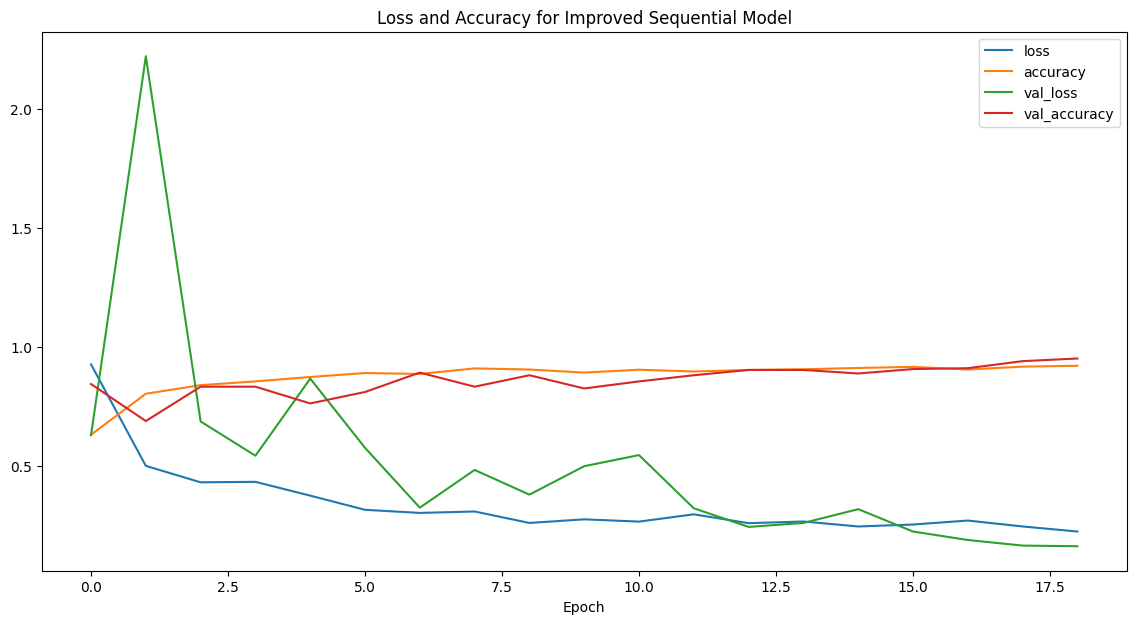

In [40]:
# showing the loss and accuracy graph for the improved model

history_imp_df.plot(figsize = (14, 7))
plt.title('Loss and Accuracy for Improved Sequential Model')
plt.xlabel('Epoch')
plt.show()

In [41]:
# evaluate the imrpoved model test-set

y_pred_imp = model_imp.predict_generator(test_dataset, 150 // 128+1)
y_pred_imp = np.argmax(y_pred_imp, axis=1)
report_imp = classification_report(test_dataset.classes, y_pred_imp, target_names = class_name)

print('Classification Report for Improved Sequential API model test-set')
print(report_imp)

Classification Report for Improved Sequential API model test-set
              precision    recall  f1-score   support

     Healthy       0.85      0.94      0.90        50
     Powdery       0.94      0.90      0.92        50
        Rust       0.98      0.92      0.95        50

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150



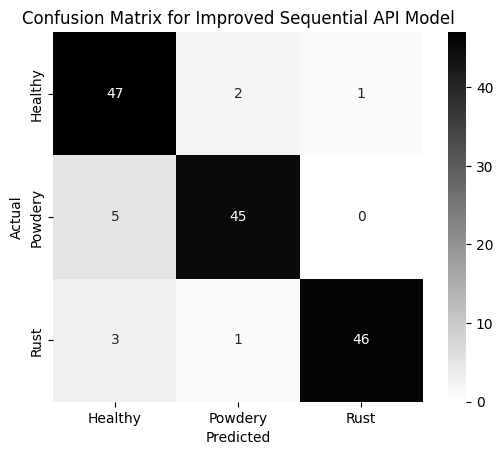

In [42]:
# showing confusion matrix for the improved model

cm_imp = confusion_matrix(test_dataset.classes, y_pred_imp)
sns.heatmap(cm_imp, annot = True, fmt = 'd', cbar = True, square = True, cmap = 'binary',
              xticklabels = class_name, yticklabels = class_name)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Improved Sequential API Model')
plt.show()

Based on the training plot, the model appears to be a <mark>good-fit</mark> as it stopped at an appropriate epoch, suggesting that <mark>further training may lead to overfitting</mark>. This observation is supported by the trend of the graph in the later epochs, indicating that the implemented `callbacks` effectively <mark>prevented overfitting</mark>.

Analyzing the <mark>confusion matrix</mark>, we observe an <mark>improvement in the accuracy</mark> of class predictions compared to the previous model. We observe an <mark>error rate of around 10%</mark> all over the classes. However, it is worth noting that the <mark>model tends to predict the Healthy class</mark> more frequently than the other classes. 

This bias towards the `Healthy` class could be attributed to various factors such as a higher similarity between the features of the `Healthy` class and the input images. Further investigation and adjustment may be necessary to address this issue and achieve a more balanced prediction across all classes.

___

## ix. Model Saving

Given that we have previously implemented `callbacks` that <mark>include model saving functionality</mark>, the current model <mark>saving becomes unnecessary</mark>.

## x. Model Inference

Model Inference will be done in the other notebook in order to avoid any errors, and it is an attempt to get as accurate results as possible.

## xi. Conclusion

In today's fast-paced landscape, advancements in technology have transformed various industries, including <mark>agriculture</mark>. Our developed model can play a <mark>crucial role in improving plant health sensitivity</mark> by accurately identifying and classifying unhealthy plants. By detecting signs of deterioration or disease at an early stage, this model <mark>enables farmers and agricultural professionals to take prompt and targeted actions</mark>, preventing further spread of diseases and optimizing crop yield and quality. 

Moreover, the integration of this model into agricultural systems provides <mark>real-time monitoring and valuable insights for decision-making, allowing farmers to optimize cultivation practices, adjust nutrient levels, and ensure overall crop well-being</mark>. This technology not only promotes sustainable farming practices but also reduces costs and environmental impact, contributing to increased crop productivity and food security.

During the exploratory data analysis (EDA) phase, we gained insights into our dataset, which comprises three distinct classes: `Healthy`, `Powdery`, and `Rust`. Initially, the dataset exhibited some class <mark>imbalance</mark>, but it was effectively addressed through <mark>proper handling</mark>. This balanced dataset serves as a foundation for achieving more accurate prediction results. Additionally, data <mark>augmentation</mark> techniques such as <mark>shear, zoom, and rotation</mark> were applied to enhance the dataset by introducing <mark>variations and diversifying the training samples</mark>. These augmentation methods contribute to a more robust and generalized model, capable of effectively recognizing and classifying plant diseases across different instances and variations in input images.

For plant disease recognition, it is recommended to <mark>prioritize accuracy</mark>. This is due to the importance of achieving <mark>precise classifications for each class</mark>, considering the potential need for <mark>different treatments based on the identified condition</mark>. By focusing on accuracy, the model can reliably identify and differentiate between healthy plants and those affected by powdery or rust diseases, enabling effective decision-making and targeted interventions.

Both the <mark>original and improved models exhibit a good statistical fit</mark>, characterized by minimal gaps between the loss and accuracy curves and their respective validation curves. The `InceptionResNetV2` pre-trained model served as the foundation for feature extraction, with additional layers such as <mark>dropout, batch normalization, and ReLU activation incorporated to enhance performance</mark>. The inclusion of <mark>callbacks</mark> in the improved model helps optimize training time based on predefined criteria. The overall <mark>results</mark> of the improved model demonstrate notable <mark>enhancements</mark>, particularly in accurately predicting the correct class.

A key <mark>strength</mark> of our model lies in its ability to <mark>automate</mark> repetitive tasks through effective computer vision. This enables the model to perform visual analysis, reducing the reliance on manual intervention and enhancing operational efficiency. For instance, in the context of <mark>drones</mark>, the model can capture images and provide real-time predictions, resulting in significant benefits for companies in terms of <mark>cost reduction, time efficiency, and improved productivity</mark>.

However, a notable <mark>weakness</mark> inherent in our model, as well as other computer vision models in general, is the challenge of <mark>generalization</mark>. The model may <mark>struggle</mark> when faced with unseen or novel scenarios that <mark>differ significantly from the training data</mark>. Factors such as changes in lighting conditions, viewpoints, or object variations can affect the model's performance and its ability to generalize accurately.

To <mark>improve</mark> a computer vision model, several actions can be applied. First, gather a diverse and representative training dataset to enhance generalization. Apply data augmentation techniques like rotation and flipping to expand the dataset. Utilize pre-trained models and fine-tune them for our specific task. Experiment with different model architectures, regularization techniques, and hyperparameter tuning. Consider ensemble methods to combine model predictions. Clean and preprocess the data properly. Regularly evaluate the model's performance and iterate based on the results. Incorporate domain-specific knowledge or techniques when applicable. Finally, always remember to stay updated with the latest research and techniques in the field.